This code provides an example of training a 3-sphere elastic microswimmer using reinforcement learning. For detailed information on the physics, please refer to the paper: 'Emergence of Odd Elasticity in a Microswimmer Using Deep Reinforcement Learning' listed in the references below.

Additionally, the PyTorch documentation for DQN is an excellent resource for understanding this algorithm. For further exploration of advanced RL algorithms, you may find the RL Adventure series on GitHub helpful.

References:

1. https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.033016
   (Emergence of Odd Elasticity in a Microswimmer Using Deep Reinforcement Learning)

2. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
   (Reinforcement Learning (DQN) Tutorial)

3. https://github.com/henanmemeda/RL-Adventure-2
   (RL Adventure)

In [ ]:
import math
import random
import numpy as np
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import time

import matplotlib
import matplotlib.pyplot as plt

project_name = '3SphereSwimmer'
main_directory = './data/'
save_base_directory = os.path.join(main_directory, project_name)
if not os.path.exists(save_base_directory):
    os.makedirs(save_base_directory)

timer_start = time.time()

In [ ]:
# Swimmer parameters
centre_of_vibration = 10  # The constant \ell in the paper
amplitude = 2  # The range within which the natural length can vary
min_L = centre_of_vibration - amplitude  # Minimum natural length of springs
num_of_segments = 4  # The number of segments in the natural length where an action changes the length for one segment
        # Given centre_of_vibration = 10 and amplitude = 2, the natural length can change within four segments:
        # (8 <-> 9, 9 <-> 10, 10 <-> 11, or 11 <-> 12)
actuation_velocity = 2.0  # The actuation velocity, referring to the natural length change rate as described in the paper

"""
Let us start with coding the 3-sphere swimmer's environment
"""
class MicroSwimmerEnv:
    def __init__(self, L1, L2, L01, L02, AMP=amplitude, COV=centre_of_vibration, dt=0.01, SEGMENTS=num_of_segments,
                 OMEGA=actuation_velocity, PLOT=False):
        """
        Initializes a new instance of the MicroSwimmerEnv class with the given initial L1, L2, L01, L02.

        :param L1:  The exact length of the left spring.
        :param L2:  The exact length of the right spring.
        :param L01: The natural length of the left spring (default: 10.0).
        :param L02: The natural length of the right spring (default: 10.0).
        :param W:   A constant speed for changing the natural length of the spring (the "actuation velocity"),
                    this number will be designated to W1 or W2 depends on the action being choosen (default: 0.334).
        :param W1:  Left natural length change rate (default: 0.0).
        :param W2:  Right natural length change rate (default: 0.0).
        :param dt:  The minimum time step used in the hydrodynamic simulation.
        """
        self.L1 = L1
        self.L2 = L2
        self.L01 = L01
        self.L02 = L02
        self.AMP = AMP
        self.COV = COV
        self.SEGMENTS = SEGMENTS
        self.W = OMEGA
        self.W1 = 0.
        self.W2 = 0.
        self.tot_dist = 0.0  # For later use to record the total distance that the swimmer swims
        self.numerical_step_reward = 0. # reward: positive net center-of-mass displacement
        self.dt = dt

        self.PLOT = PLOT # False as default
        self.PLOT_STATE = [] # List to save all state's history if PLOT=True

    # define the actions of the microswimmer
    def translate_action(self, action): # translate action codes into corresponding physical motions
        """
        Define the action of the swimmer.
        - Action 0: increases the natural length of the left arm.
        - Action 1: increases the natural length of the right arm.
        - Action 2: decreases the natural length of the left arm.
        - Action 3: decreases the natural length of the right arm.
        # No movement when swimmer choose action that surpass the constraints (amplitude)
        """
        self.W1 = 0
        self.W2 = 0  # W1, W2's value initializing
        dt_times_W = self.W * self.dt
        COV = self.COV
        AMP = self.AMP

        if action == 0:
            if self.L01 + dt_times_W <= COV + AMP:
                self.W1 = self.W # assign constant change rate only if motion obey the constraint
            else:
                self.L01 = COV + AMP # else no assignment and clip the natural length
        elif action == 1:
            if self.L02 + dt_times_W <= COV + AMP:
                self.W2 = self.W
            else:
                self.L02 = COV + AMP
        elif action == 2:
            if self.L01 - dt_times_W >= COV - AMP:
                self.W1 = - self.W
            else:
                self.L01 = COV - AMP
        elif action == 3:
            if self.L02 - dt_times_W >= COV - AMP:
                self.W2 = - self.W
            else:
                self.L02 = COV - AMP
        else:
            self.W1, self.W2 = [0, 0]  # No movement

    def update_params_L0(self):
        """
        Action translated -> updating L01, L02 -> determine the net force f1, f3 -> updating L1, L2
        """
        dt_times_W1 = self.dt * self.W1
        dt_times_W2 = self.dt * self.W2
        self.L01 += dt_times_W1
        self.L02 += dt_times_W2

    def reward_calculate(self):
        # Calculate the centre of mass velocity and then add CMV * dt to the total distance
        l1 = self.L1
        l2 = self.L2
        l01 = self.L01
        l02 = self.L02

        CMV = 1 / 2 * ((1 / (l1 + l2) - 1 / l2) * (l1 - l01) + (1 / (l1 + l2) - 1 / l1) * -(l2 - l02))
        self.numerical_step_reward = CMV * self.dt
        self.tot_dist += self.numerical_step_reward


    def update_params_L(self):
        l1 = self.L1
        l2 = self.L2
        l01 = self.L01
        l02 = self.L02
        f1 = (l1 - l01)
        f3 = -(l2 - l02)

        vL1 = (3 / 2 * f1 / l1 + (-f1 - f3) + 3 / 2 * f3 / l2) - (
                f1 + 3 / 2 * (-f1 - f3) / l1 + 3 / 2 * f3 / (l1 + l2))
        vL2 = (3 / 2 * f1 / (l1 + l2) + 3 / 2 * (-f1 - f3) / l2 + f3) - (
                3 / 2 * f1 / l1 + (-f1 - f3) + 3 / 2 * f3 / l2)
        dt_times_vL1 = self.dt * vL1
        dt_times_vL2 = self.dt * vL2
        self.L1 += dt_times_vL1
        self.L2 += dt_times_vL2

    def simulate(self, action):
        max_num_numerical_steps = (2 * self.AMP) / (self.W * self.dt) # the amount of numerical step we have in the amplitude interval
        segment_size = int(max_num_numerical_steps / self.SEGMENTS)

        for i in range(segment_size):

            # To plot preciser, recording all data in the minimum time scale. Only initiated when PLOT=True is assigned.
            if self.PLOT is True: self.PLOT_STATE.append([self.L1, self.L2, self.L01, self.L02, self.numerical_step_reward])

            self.translate_action(action)  # Now the value of W1, W2 is assigned depending on `action`
            self.update_params_L0()
            self.reward_calculate()
            self.update_params_L()

        return self.tot_dist  # return the total distance


In [ ]:
"""
Replay Memory
where we record all transitions.
"""
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    # In Python 3, all classes implicitly inherit from `object`, so specifying it is optional.

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  # `maxlen` sets a limit on the number of stored transitions.

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))  # When `maxlen` is reached, appending removes the oldest element.

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions.
        This is useful for training the agent using mini-batches.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
"""
Defining our neural network
"""

n_actions = 4
n_observations = 4

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, fc1_dim, fc2_dim, fc3_dim, lr):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, fc1_dim)
        self.layer2 = nn.Linear(fc1_dim, fc2_dim)
        self.layer3 = nn.Linear(fc2_dim, fc3_dim)
        self.layer4 = nn.Linear(fc3_dim, n_actions)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device) # to GPU

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, amsgrad=True)

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x), negative_slope=0.1)
        x = F.leaky_relu(self.layer2(x), negative_slope=0.1)
        x = F.leaky_relu(self.layer3(x), negative_slope=0.1)
        return self.layer4(x)


In [ ]:
"""
Agent
"""

# Agent's Hyperparameter
STEPS_LIMIT = 1200
MEMORY_LENGTH = STEPS_LIMIT * 200
BATCH_SIZE = 64
GAMMA = 0.99  # far-sighted
EPS_START = 0.9
EPS_END = 0.02
EPS_DECAY = STEPS_LIMIT * 20  # smaller the faster to train, but may not have enough exploration
MAX_TEMP = 10
TAU = 0.005
LR = 2e-5
FC1_DIM = 256
FC2_DIM = 128
FC3_DIM = 128

steps_done = 0 # for the epsilon decay

class Agent():
    def __init__(self, GAMMA=GAMMA, epsilon=EPS_START, LR=LR, TAU=TAU, fc1_dim=FC1_DIM, fc2_dim=FC2_DIM,
                 fc3_dim=FC3_DIM, BATCH_SIZE=BATCH_SIZE, n_observations=n_observations, n_actions=n_actions,
                 memory_length=MEMORY_LENGTH, EPS_START=EPS_START, EPS_DECAY=EPS_DECAY):
        self.gamma = GAMMA
        self.eps_start = EPS_START
        self.eps_end = EPS_END
        self.eps_dec = EPS_DECAY
        self.memory_length = MEMORY_LENGTH
        self.batch_size = BATCH_SIZE
        self.tau = TAU

        self.memory = ReplayMemory(memory_length)

        # instantiate networks
        self.policy_net = DQN(n_observations, n_actions, fc1_dim, fc2_dim, fc3_dim, LR)
        self.target_net = DQN(n_observations, n_actions, fc1_dim, fc2_dim, fc3_dim, LR)
        self.target_net.load_state_dict(self.policy_net.state_dict()) # The target network should initially have the same parameters as the policy network.
        # self.target_net.eval --> if there are layers like batchnorm or dropout
        """
        Exercise: when do we need .eval mode?
        """

        self.soft_update() # this function is defined at the end of this cell


    def choose_action(self, observation):  # Epsilon-Greedy Algorithm
        global steps_done
        sample = random.random()  # Returns a random float x: 0.0 <= x < 1.0
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * steps_done / self.eps_dec)
        steps_done += 1

        if sample > eps_threshold:  # If the sample is greater than the threshold, use the policy network
            temperature = 0.0001  # This constant value seems a bit non-sense, but
                                  # it is intentionally small to select the action with the highest Q-value.
                                  # Though a higher temperature would apply more randomness, I found it not needed here.
            """
            Alternative approach:
            temperature = max(0.001, MAX_TEMP * EPS_START * math.exp(-1. * steps_done / EPS_DECAY))
            The decaying temperature adds randomness at the beginning and reduces it as training progresses.
            When the temperature is near zero, the softmax function acts like a step function, where the highest
            Q-value has a probability of 1, and all others have a probability of 0.

            However, in this system, a small temperature generally improves training efficiency.
            """
            with torch.no_grad():
                # Get the policy network's output
                output = self.policy_net(state)
                # Apply softmax with temperature to get a probability distribution
                action_probs = F.softmax(output / temperature, dim=-1)
                # Sample an action based on the distribution
                action = torch.multinomial(action_probs, 1)
                return action

        else:
            # Choose a random action
            return torch.tensor([[np.random.choice(n_actions)]], device=self.policy_net.device, dtype=torch.long)

    def memorize(self, state, action, next_state, reward):   # store a transition
        self.memory.push(state, action, next_state, reward)

    def learn(self):
        # First, check if there are enough transitions in memory to sample a batch
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of transitions from memory
        transitions = self.memory.sample(self.batch_size)

        # Transpose the batch of transitions to a transition of batches
        batch = Transition(*zip(*transitions))
        """
        (see https://stackoverflow.com/a/19343/3343043 for detailed explanation).
        This converts batch-array of Transitions to Transition of batch-arrays.
        """

        # Create a boolean mask for non-final next states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                      device=self.policy_net.device, dtype=torch.bool)
        """
        e.g.: (non-final, final, non-final, non-final, final) -> (1, 0, 1, 1, 0)
        """

        # Concatenate non-final next states into a single tensor
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        """
        e.g.: (non-final, final, non-final, non-final, final) -> (non-final, non-final, non-final)
        """

        # Concatenate states, actions, and rewards into batch tensors
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a_t) for the state-action pairs in the batch
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all non-final next states by taking the max Q value of the target network
        next_state_values = torch.zeros(self.batch_size, device=self.policy_net.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        """
        Values of actions are computed using the target_net, expected those for final states remains 0

        e.g.: (0, 0, 0, 0, 0) -> (value1, 0, value2, value3, 0)
        """

        # Compute the expected state-action values for the batch
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute the Huber loss between the expected and actual state-action values
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # loss backward
        self.policy_net.optimizer.zero_grad()
        loss.backward()

        # Clip the gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)

        # Update the policy network using the AdamW optimizer
        self.policy_net.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self):
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 − τ)θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1 - self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

        """
        For the soft update, we only update the target_net.
        The policy_net is updated using optimizer.step() based on
        the loss calculated during reinforcement learning.
        """


In [ ]:
"""
Function to plot the training curve.
"""
episode_rewards = []
test_episode_rewards = []

# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

def plot_rewards(show_result=False):
    """
    Plot the total rewards obtained in each episode and optionally the running average over 10 episodes.

    Args:
        show_result (bool): Whether to show the plot as a final result or as a training visualization.
    """
    plt.figure(1)

    # Convert episode_rewards to a tensor of float numbers
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()  # Clear the current figure
        plt.title('Training... Actuation velocity = ' + str(actuation_velocity))

    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')

    # Plot the total rewards for each episode (data converted to numpy for plotting)
    plt.plot(rewards_t.numpy(), color='blue', label='Train Rewards')

    # Plot the 10-episode running average if enough data is available
    if len(rewards_t) >= 10:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)  # Calculate the mean of every 10 episodes
        """
        This calculates the mean over every 10 steps (1 to 10, 2 to 11, 3 to 12, ...).
        view() reshapes it into a 1D tensor for plotting.
        """
        means = torch.cat((torch.zeros(9), means))  # Pad the start of the tensor with zeros for alignment
        plt.plot(means.numpy(), color='orange', label='10-episode average Train Rewards')

    # Pause briefly to update the plot
    plt.pause(0.001)

    # If running in IPython, display the plot
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())  # gcf: Get the current figure and display it
            display.clear_output(wait=True)  # Clear the output before displaying the next update
        else:
            display.display(plt.gcf())
            fig_filename = f"training_curve.png"
            fig_path = os.path.join(save_base_directory, fig_filename)
            plt.savefig(fig_path)

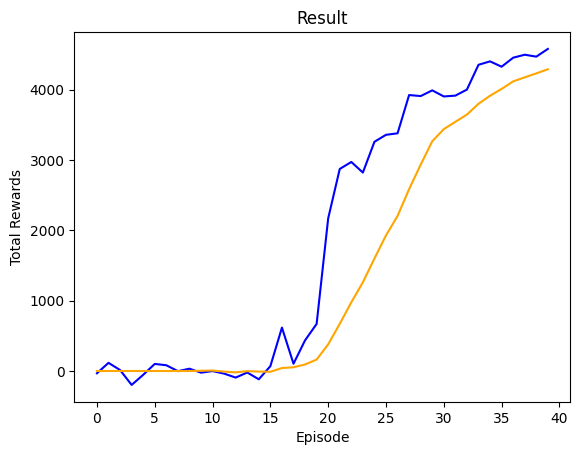

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
Main training loop for training a microswimmer using reinforcement learning.
"""

# Random initialization
def generate_initial_conditions():
    # Randomly generate initial arm lengths for exploration
    initial_L1_length = round(random.uniform(centre_of_vibration - amplitude, centre_of_vibration + amplitude), 4)
    initial_L2_length = round(random.uniform(centre_of_vibration - amplitude, centre_of_vibration + amplitude), 4)
    initial_L01_length = round(random.uniform(centre_of_vibration - amplitude, centre_of_vibration + amplitude), 4)
    initial_L02_length = round(random.uniform(centre_of_vibration - amplitude, centre_of_vibration + amplitude), 4)

    return initial_L1_length, initial_L2_length, initial_L01_length, initial_L02_length

# Initializing the agent
agent = Agent()

num_episodes = 40  # Number of episodes to run
for i_episode in range(num_episodes):

    # Initialize environment and agent for each episode
    initial_L1_length, initial_L2_length, initial_L01_length, initial_L02_length = generate_initial_conditions()
    env = MicroSwimmerEnv(initial_L1_length, initial_L2_length, initial_L01_length, initial_L02_length)
    state = torch.tensor([[env.L1 - min_L, env.L2 - min_L, env.L01 - min_L, env.L02 - min_L]],
                         dtype=torch.float32, device=agent.policy_net.device)

    total_rewards = 0
    done = False

    # Loop through each step in the episode
    for t in count():  # `count(start=0, step=1)` increments until a `break` occurs

        # The agent selects an action (Epsilon-Greedy) and simulates it in the environment
        action = agent.choose_action(state)
        new_tot_rewards = env.simulate(action.item())

        # Scale the reward and update the total rewards
        new_tot_rewards = new_tot_rewards * 1000  # Reward scaling
        observation = np.array(
            [env.L1 - min_L, env.L2 - min_L, env.L01 - min_L, env.L02 - min_L],
            dtype=np.float32)
        reward = new_tot_rewards - total_rewards
        reward = torch.tensor([reward], dtype=torch.float32, device=agent.policy_net.device)

        # Check if the episode is done
        if t == STEPS_LIMIT - 1:
            done = True
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32,
                                      device=agent.policy_net.device).unsqueeze(0)

        # Store the transition in the agent's memory
        agent.memorize(state, action, next_state, reward)

        # Update the state and total rewards for the next iteration
        state = next_state
        total_rewards = new_tot_rewards

        # Optimize the policy network (one iteration)
        agent.learn()

        if done:
            episode_rewards.append(total_rewards)
            plot_rewards()
            break  # Proceed to the next episode

# Save the training curve
fig_filename = "training_curve.png"
fig_path = os.path.join(save_base_directory, fig_filename)
plt.savefig(fig_path)

# Save the policy network's state dictionary
filename = 'policy_net_.pth'
PATH = os.path.join(save_base_directory, filename)
torch.save(agent.policy_net.state_dict(), PATH)

# Turn off interactive mode to make the plot persist
plt.ioff()
# Plot the final results
plot_rewards(show_result=True)

# Let us now validate our model result with 10 different initial conditions.

In [ ]:
import copy  # For deepcopy

"""
Creating ten_memories (list) to store data from 10 different initial states.
"""
ten_dt_memories = []
number_of_ini = 10

# Initializing environment and agent for each episode
initial_L1_length, initial_L2_length, initial_L01_length, initial_L02_length = generate_initial_conditions()
env = MicroSwimmerEnv(initial_L1_length, initial_L2_length, initial_L01_length, initial_L02_length)
state = torch.tensor([[env.L1 - min_L, env.L2 - min_L, env.L01 - min_L, env.L02 - min_L]],
                     dtype=torch.float32, device=agent.policy_net.device)

STEPS_LIMIT = 240
done = False

for i in range(number_of_ini):
    # Generate initial conditions for the test environment
    iniL1, iniL2, iniL01, iniL02 = generate_initial_conditions()
    test_env = MicroSwimmerEnv(iniL1, iniL2, iniL01, iniL02, PLOT=True)  # PLOT is set to True for visualization data

    # Initialize the state based on the initial conditions
    state = torch.tensor([[test_env.L1 - min_L, test_env.L2 - min_L, test_env.L01 - min_L,
                           test_env.L02 - min_L]], dtype=torch.float32,
                         device=agent.policy_net.device)
    total_rewards = 0
    done = False

    # Loop through the steps in the episode
    for t in count():
        with torch.no_grad():
            # Get the output from the policy network
            output = agent.policy_net(state)
            # Select the action with the highest Q-value
            action = output.max(1)[1].view(1, 1)

        # Simulate the action in the environment and scale the reward
        total_rewards = test_env.simulate(action.item()) * 1000.

        # Update the state
        state = torch.tensor(
            [test_env.L1 - min_L, test_env.L2 - min_L, test_env.L01 - min_L, test_env.L02 - min_L],
            dtype=torch.float32, device=agent.policy_net.device).unsqueeze(0)

        # Break the loop if the step limit is reached
        if t == STEPS_LIMIT - 1:
            break

    print(f"Total reward: {total_rewards}")

    """
    Copy recorded data from PLOT_STATE to avoid aliasing.

    Without deepcopy, the data in ten_dt_memories would be affected when PLOT_STATE is cleared.
    This happens due to aliasing—both variables would reference the same memory.
    """
    plot_states_copy = copy.deepcopy(test_env.PLOT_STATE)
    ten_dt_memories.append(plot_states_copy)
    test_env.PLOT_STATE.clear()

print("Plot data collection complete!")

Total reward: 1059.1766566398674
Total reward: 1081.5547688136426
Total reward: 1001.0105627027813
Total reward: 1067.661051793294
Total reward: 1046.1818373119522
Total reward: 1084.5706134632974
Total reward: 1020.1513083846368
Total reward: 1061.1992537324063
Total reward: 1096.4020213431884
Total reward: 1038.5500519660843
Plot data collection complete!


# With the collected data, we can now plot the configurational phase diagrams

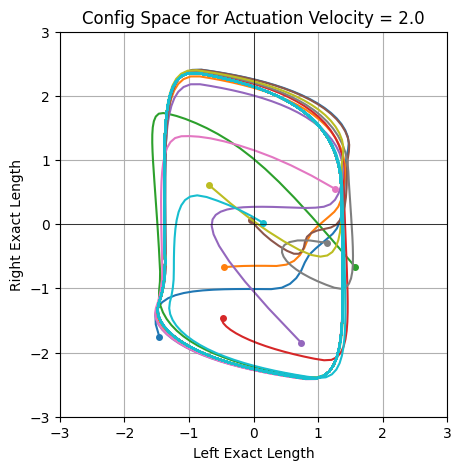

In [ ]:
# Initialize empty lists to store shifted left and right exact lengths
shifted_left_exact_lengths = []
shifted_right_exact_lengths = []

fig, ax = plt.subplots(figsize=(5, 5))  # Create a figure and axis for plotting

for memory_set in ten_dt_memories:
    # Clear the lists for each new memory set
    shifted_left_exact_lengths.clear()
    shifted_right_exact_lengths.clear()

    # Iterate through the memory set, taking every 10th step
    for i in range(len(memory_set) // 10):
        # Access the left and right exact lengths for the current time step
        plot_state = memory_set[i * 10]
        left_exact_length = plot_state[0]
        right_exact_length = plot_state[1]

        # Shift the lengths relative to the centre of vibration
        shifted_left_exact_length = left_exact_length - centre_of_vibration
        shifted_right_exact_length = right_exact_length - centre_of_vibration

        # Append the shifted lengths to the respective lists
        shifted_left_exact_lengths.append(shifted_left_exact_length)
        shifted_right_exact_lengths.append(shifted_right_exact_length)

    # Plot the phase space for the current memory set
    line = ax.plot(shifted_left_exact_lengths, shifted_right_exact_lengths, marker=' ', markersize=2)[0]

    # Capture the color of the line to match the initial point's dot color
    line_color = line.get_color()

    # Plot a dot for the initial point using the same color as the line
    ax.plot(shifted_left_exact_lengths[0], shifted_right_exact_lengths[0],
            marker='o', markersize=4, color=line_color)  # Smaller dot size for initial point

# Set the limits for the plot manually
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Add labels, title, and grid lines to the plot
ax.set_xlabel('Left Exact Length')
ax.set_ylabel('Right Exact Length')
ax.set_title('Config Space for Actuation Velocity = ' + str(actuation_velocity))
ax.axhline(y=0, color='black', linewidth=0.5)  # Add horizontal line at y=0
ax.axvline(x=0, color='black', linewidth=0.5)  # Add vertical line at x=0
ax.grid(True)

# Display the plot
plt.show()

# Save the figure
fig_filename = "config_space.png"
fig_path = os.path.join(save_base_directory, fig_filename)
fig.savefig(fig_path)